<a href="https://colab.research.google.com/github/Semillero-de-Neuroinformatica-IA/DeepLearning-con-python/blob/main/Horses_vs_Humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

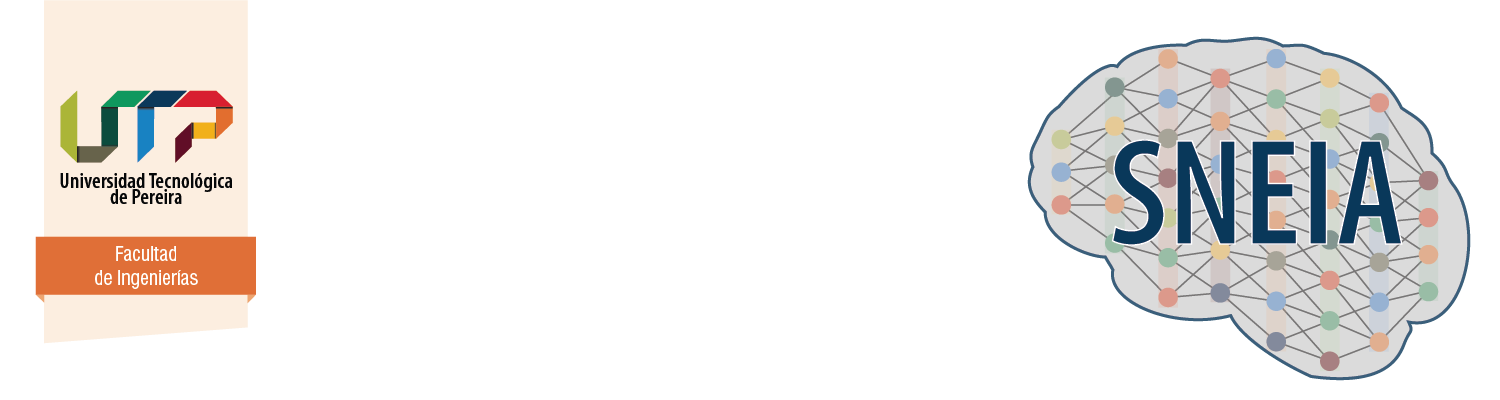

# Redes neuronales convolucionales: Horses vs Humans

En esta parte del laboratorio entrenaremos una red convolucional que nos permita hacer una clasificación binaria entre [caballos o humanos](https://www.tensorflow.org/datasets/catalog/horses_or_humans). Lo particular de la base de datos que utilizaremos es que las imágenes de entrenamiento son generadas por computador. Esta base de datos fué creada por Laurence Moroney, uno de los divulgadores de la inteligencia artificial más activos del momento.

In [4]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

--2022-10-06 19:33:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip.1’

horse-or-human.zip. 100%[===================>] 142.65M   144MB/s    in 1.0s    

2022-10-06 19:33:02 (144 MB/s) - ‘horse-or-human.zip.1’ saved [149574867/149574867]



Se utilizará el módulo [zipfile](https://docs.python.org/3/library/zipfile.html) para descomprimir el archivo.

In [5]:
import zipfile

local_file='./horse-or-human.zip'
zip_ref=zipfile.ZipFile(local_file,'r')
zip_ref.extractall('horse-or-human')
zip_ref.close()

EL contenido de los archivos .zip son extraidos en el directorio base `./horse-or-human ` , el cual sa su vez contiene subdirectorios `horses` and `humans`.

El set de entrenamiento es el encargado de decirle a la red neuronal 'así luce un caballo' y 'así luce un humano'.

El usar la API del ImageDataGenerator nos evitamos el paso de etiquetar cada una de las imágenes como 'caballo' o 'humano', el ImageDataGenerator hace este paso con base en el orden de los directorios a los cuales apunte. Por ejemplo en el directorio `training`, hay una carpeta llamada `horses` y otra llamda `humans`, con base en este orden el ImageDataGenerator generará las etiquetas por nosotros.

Se pueden definir los directorios de la siguiente manera:

In [6]:
import os

# directorio con imágenes de caballos
train_horse_dir=os.path.join('./horse-or-human/horses')

# directorrio con imágenenes de humanos
train_human_dir=os.path.join('./horse-or-human/humans')

Miremos brevemente como lucen los directorios `humans` y `horses`

In [7]:
train_horse_names=os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names=os.listdir(train_human_dir)
print(train_human_names[:10])

['horse22-9.png', 'horse24-5.png', 'horse11-3.png', 'horse14-7.png', 'horse36-7.png', 'horse41-1.png', 'horse23-8.png', 'horse06-5.png', 'horse47-5.png', 'horse05-5.png']
['human02-19.png', 'human07-28.png', 'human15-15.png', 'human12-22.png', 'human04-22.png', 'human11-26.png', 'human07-08.png', 'human17-01.png', 'human10-18.png', 'human10-27.png']


Vamos visualizar ahora 8 humanos y 8 caballos

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows=4
ncols=4

pic_index=0

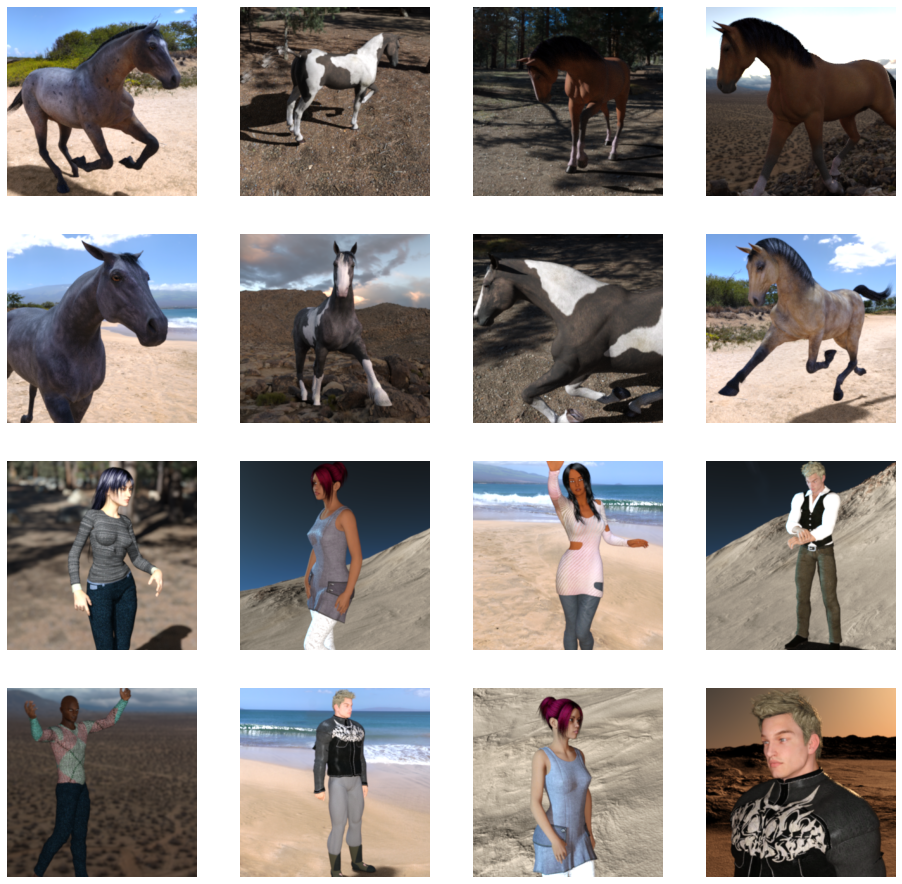

In [9]:
fig=plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)

pic_index+=8
next_horse_pic=[os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pic=[os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pic+next_human_pic):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')

  img=mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## Construcción del modelo desde cero
Con base en la librería Tensorflow, construiremos una red convolucional que alimente a una red densamente conectada. Como este es un problema de clasificación binaria, la red terminará con una neurona que tenga una función de activación [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). Este produce una salida entre uno y cero, codificando la probabilidad de que la imagen actual corresponda a la clase 1 (de lo contrario es clase 0).

La primera parte del modelo consta de una serie de operaciones de convolución sobre las imágenes, así como la operación de _maxpooling_.

Revisaremos antes el proceso de convolución y el de maxpooling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  """


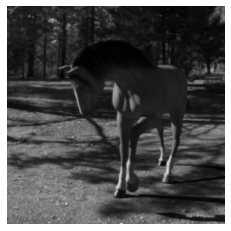

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

test_image=color.rgb2gray(mpimg.imread(os.path.join(train_horse_dir,train_horse_names[2])))
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(test_image)
plt.show()

Realicemos una copia de la imagen y determinemos su tamaño para el proceso de iteración.

In [11]:
image_transformed=np.copy(test_image)
size_x = image_transformed.shape[0]
size_y = image_transformed.shape[1]

Ahora implementemos los filtros como arreglos de 3x3 

In [12]:
# Se puede cambiar los valores para ver el efecto de los filtros
filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]

# Dos filtros mas para probar, ánimo!!!
# filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
# filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# Si los digitos del filtro no suman 0 o 1, se debe añadir un peso para normalizar
# Ejemplo, si la suma es 10, se utiliza un peso de weight=0.1
weight  = 1

### Efecto de la convolución
Aplicamos la convolución a la imagen

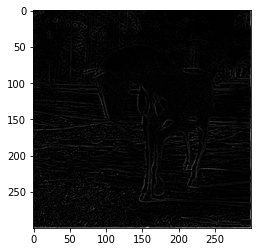

In [13]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
    convolution = 0.0
    convolution = convolution + (test_image[x-1, y-1] * filter[0][0])
    convolution = convolution + (test_image[x-1, y] * filter[0][1])  
    convolution = convolution + (test_image[x-1, y+1] * filter[0][2])     
    convolution = convolution + (test_image[x, y-1] * filter[1][0])    
    convolution = convolution + (test_image[x, y] * filter[1][1])    
    convolution = convolution + (test_image[x, y+1] * filter[1][2])    
    convolution = convolution + (test_image[x+1, y-1] * filter[2][0])    
    convolution = convolution + (test_image[x+1, y] * filter[2][1])    
    convolution = convolution + (test_image[x+1, y+1] * filter[2][2])    
      
      # Multiplicamos por peso
    convolution = convolution * weight   
      
      # verificamos los límites
    if(convolution<0):
      convolution=0
    if(convolution>255):
      convolution=255

      # cargamos la imagen transormada
    image_transformed[x, y] = convolution

plt.gray()
plt.grid(False)
plt.imshow(image_transformed)
plt.show()  

### Aplicamos el maxpooling
El max pooling es el proceso por el cuál escogemos el máximo de cada grupo de 4 pixeles vecinos.

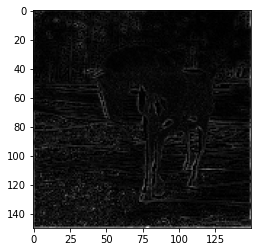

In [14]:
# Asignamos las dimensiones a la mitad de la imagen inicial
new_x = int(size_x/2)
new_y = int(size_y/2)

# Creamos una imagen limpia con las nuevas dimensiones
newImage = np.zeros((new_x, new_y))

# Iteramos sobre la imagen
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):
    
    # Almacenamos todos los valores del pool
    pixels = []
    pixels.append(image_transformed[x, y])
    pixels.append(image_transformed[x+1, y])
    pixels.append(image_transformed[x, y+1])
    pixels.append(image_transformed[x+1, y+1])

    # Tomamos el mayor y lo asignamos a la nueva imagen
    newImage[int(x/2),int(y/2)] = max(pixels)

# Graficamos la nueva imagen
plt.gray()
plt.grid(False)
plt.imshow(newImage)
plt.show()   

### montamos la arquitectura de la red
Con base en la librería Tensorflow, construiremos una red convolucional que alimente a una red densamente conectada. Como este es un problema de clasificación binaria, la red terminará con una neurona que tenga una función de activación [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). Este produce una salida entre uno y cero, codificando la probabilidad de que la imagen actual corresponda a la clase 1 (de lo contrario es clase 0).


In [15]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Esta es la primer convolución, acá definimos que la señal de entrada sea 300x300 con 3 canales pal color
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #La segunda convolución
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #La tercera convolución
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #La cuarta convolución
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #La quinta convolución
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten para alimentar la red neuronal
    tf.keras.layers.Flatten(),
    #Capa oculta de 512 neuronas escondidas
    tf.keras.layers.Dense(512, activation='relu'),
    #Solo una neurona de salida. Contendrá un valor entre 0 y 1
    tf.keras.layers.Dense(1, activation='sigmoid')

])

Revisemos la arquitectura creada utilizando `model.summary().`

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

### Compilación del modelo
Se entrenará el modelo con la pérdida `binary_crossentropy` ya que estamos frente a un problema de clasificación binaria, y la activación final será una tipo `sigmoid`. Vamos usar optimizador `Adam`, ya que a diferencia de `SGD` este permite que la tasa de aprendizaje se ajuste automáticamente. Se monitoreará la precisión (`accuracy`), durante el entrenamiento.

In [17]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics='Accuracy')



## Procesamiento de datos
El siguiente paso es configurar los generadores de datos que van a leer nuestras imágenes de los folders, las convertirán a punto flotante, y las pasarán (con sus labels) al modelo. Estos generadores pasarán _batches_ de imagenes de (300 x 300) y sus _labels_ binarios.

Al igual que en todo problema de visión por computador con redes neuronales, los niveles de la imagen deben ser normalizados para tener imagenes cuyos pixeles esten en el rango [0-1]. 

En Keras, este proceso se puede realizar con la clase `keras.preprocessing.image.ImageDataGenerator` usando en parámetro `rescale`. Esta clase `ImageDataGenerator` permite realizar tener _augmented batches_ de imágenes (y sus _labels_) por medio de los métodos `.flow(data,labels)` o `.flow_from_directory`. 

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# se reescalan las imagenes
train_datagen = ImageDataGenerator(rescale=1/255)

# se genera un flujo de imágenes en batches de 128 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
    './horse-or-human/',
    target_size=(300,300),
    batch_size=128,
    # se usa como perdida binary_crossentropy, se necesitan entonces labels binarios
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


## Entrenamiento

Vamos a iniciar con 15 epocas. Durante el entrenamiento debemos monitorear la perdida (_loss_) y la presición (_accuracy_). La pérdida mide la predicción del modelo contra los _labels_ conocidos, calculando el resultado. La precisión, por otro lado, es la proporción de predicciones correctas.

In [19]:
history=model.fit(
    train_generator, steps_per_epoch=8,
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 17s 644ms/step - loss: 0.6469 - Accuracy: 0.6251
Epoch 2/15
8/8 [==============================] - 7s 734ms/step - loss: 0.3593 - Accuracy: 0.8621
Epoch 3/15
8/8 [==============================] - 6s 718ms/step - loss: 0.2527 - Accuracy: 0.9110
Epoch 4/15
8/8 [==============================] - 6s 707ms/step - loss: 0.1479 - Accuracy: 0.9388
Epoch 5/15
8/8 [==============================] - 6s 706ms/step - loss: 0.0625 - Accuracy: 0.9755
Epoch 6/15
8/8 [==============================] - 6s 697ms/step - loss: 0.0393 - Accuracy: 0.9844
Epoch 7/15
8/8 [==============================] - 7s 792ms/step - loss: 0.0242 - Accuracy: 0.9922
Epoch 8/15
8/8 [==============================] - 7s 780ms/step - loss: 0.0104 - Accuracy: 0.9989
Epoch 9/15
8/8 [==============================] - 6s 691ms/step - loss: 0.0100 - Accuracy: 0.9967
Epoch 10/15
8/8 [==============================] - 6s 701ms/step - loss: 0.0437 - Accuracy: 0.9867
Epoch 11/15
8/8 [=

## Modelo predictivo

Ahora haremos una predicción con nuestro modelo. Con el snippset mostrado a continuación, permite cargar imágenes que serán pasadas al modelo, dando una indicación de si se trata de un humano o un caballo.

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
    
  if classes[0]>0.5:
    print(fn + " es un humano")
  else:
    print(fn + " es un caballo")

Saving white-horse-3010129_1920.jpeg to white-horse-3010129_1920.jpeg
[8.4944586e-05]
white-horse-3010129_1920.jpeg es un caballo
